# Prediksi Customer Churn di Perusahaan E-Commerce

# Business Problem

## Latar Belakang
Perusahaan e-commerce ingin mengurangi tingkat **customer churn** (kehilangan pelanggan) yang berdampak pada turunnya pendapatan dan meningkatnya biaya akuisisi pelanggan baru.  
Saat ini, tim bisnis menggunakan strategi sederhana:
1. **Treat All** — Mengasumsikan semua pelanggan akan churn dan memberikan penawaran retention ke semua pelanggan.
2. **Treat None** — Mengasumsikan semua pelanggan akan loyal dan tidak memberikan intervensi apapun.

Kedua strategi tersebut belum efisien:
- **Treat All** → Biaya retention membengkak karena menargetkan pelanggan yang sebenarnya tidak akan churn.
- **Treat None** → Kehilangan pelanggan churn tanpa usaha mempertahankannya.

---

## Tujuan
Membangun model Machine Learning untuk **memprediksi pelanggan yang berisiko churn**, sehingga perusahaan dapat:
- Menargetkan upaya retention hanya pada pelanggan yang benar-benar berisiko tinggi.
- Mengoptimalkan penggunaan anggaran pemasaran.
- Mengurangi total biaya gabungan (retention + akuisisi).

---

## Stake Holder
Model ini akan ditujukan untuk tim marketing untuk membuatkan prediksi customer churn atau tidak. Jika churn, akan diberikan retention cost (promo dan voucher)

---
## Definisi Churn
- **0** = Loyal (tidak churn)
- **1** = Churn (berhenti menjadi pelanggan aktif)

---

## Sebelum Menggunakan Machine Learning
Berdasarkan confusion matrix dari **kondisi sebelum menggunakan model ML**:

<img src='CM_before_ML.png'>


**Total pelanggan** = 789  
**Total churn sebenarnya** = 135  
**Total loyal sebenarnya** = 654

---

## Asumsi Biaya
- **Acquisition cost (A)** = Rp 150.000 / pelanggan baru
- **Retention cost (R)** = Rp 20.000 / pelanggan yang diberi treatment

---

## Perhitungan Biaya Baseline

### **Skenario 1 — Treat All**
- Biaya retention = 789 × Rp 20.000 = **Rp 15.780.000**
- Biaya retention yang diperlukan sebenarnya = 135 x Rp 20.000 = **Rp 2.700.000**
- **Total biaya kerugian perusahaan akibat menganggap semua churn adalah = Rp 13.080.000**

### **Skenario 2 — Treat None**
- Biaya akuisisi = 135 × Rp 150.000 = **Rp 20.250.000**
- **Total biaya = Rp 20.250.000**

---

## Insight dari Baseline
- **Treat None** lebih mahal dari **Treat All** jika hanya menghitung biaya langsung.
- Tanpa model ML, kedua strategi tidak efisien dan berpotensi membuang anggaran atau kehilangan potensi pendapatan.

---

## Metrics Selection

Metrics yang akan saya gunakan sebagai evaluasi adalah F-3 Score (lebih ekstrim menekan False Negative ketimbang False Positive). Karena saya ingin menekan jumlah False Negative (mengurangi acqusition cost) dan tidak terlalu mengabaikan False Postive(retention cost).

# Data Understanding

| Fitur                  | Deskripsi                                                                 |
|------------------------|---------------------------------------------------------------------------|
| Tenure                 | Lama waktu pelanggan bergabung di perusahaan.                            |
| WarehouseToHome        | Jarak antara gudang dan rumah pelanggan.                                  |
| NumberOfDeviceRegistered | Jumlah perangkat yang terdaftar pada pelanggan tertentu.                |
| PreferedOrderCat       | Kategori pesanan yang paling sering dipilih pelanggan dalam sebulan terakhir. |
| SatisfactionScore      | Skor kepuasan pelanggan terhadap layanan.                                 |
| MaritalStatus          | Status pernikahan pelanggan.                                              |
| NumberOfAddress        | Jumlah alamat yang terdaftar pada pelanggan tertentu.                     |
| Complaint              | Apakah ada keluhan yang diajukan dalam sebulan terakhir.                  |
| DaySinceLastOrder      | Jumlah hari sejak pesanan terakhir oleh pelanggan.                        |
| CashbackAmount         | Rata-rata cashback dalam sebulan terakhir.                                |



---
| Target                 | Deskripsi                                                                 |
|------------------------|---------------------------------------------------------------------------|
| Churn                  | Penanda apakah pelanggan churn atau loyal.                    |

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier


from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')



## Load Dataset

In [2]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


## Data Cleaning

### Drop Duplicate

In [4]:
df.duplicated().sum()

671

Disini saya akan menghapus 671 baris data yang duplikat.

In [5]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3110 non-null   float64
 1   WarehouseToHome           3135 non-null   float64
 2   NumberOfDeviceRegistered  3270 non-null   int64  
 3   PreferedOrderCat          3270 non-null   object 
 4   SatisfactionScore         3270 non-null   int64  
 5   MaritalStatus             3270 non-null   object 
 6   NumberOfAddress           3270 non-null   int64  
 7   Complain                  3270 non-null   int64  
 8   DaySinceLastOrder         3089 non-null   float64
 9   CashbackAmount            3270 non-null   float64
 10  Churn                     3270 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 306.6+ KB


### Cek Missing Value

In [6]:
df.isna().sum()

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

<Axes: >

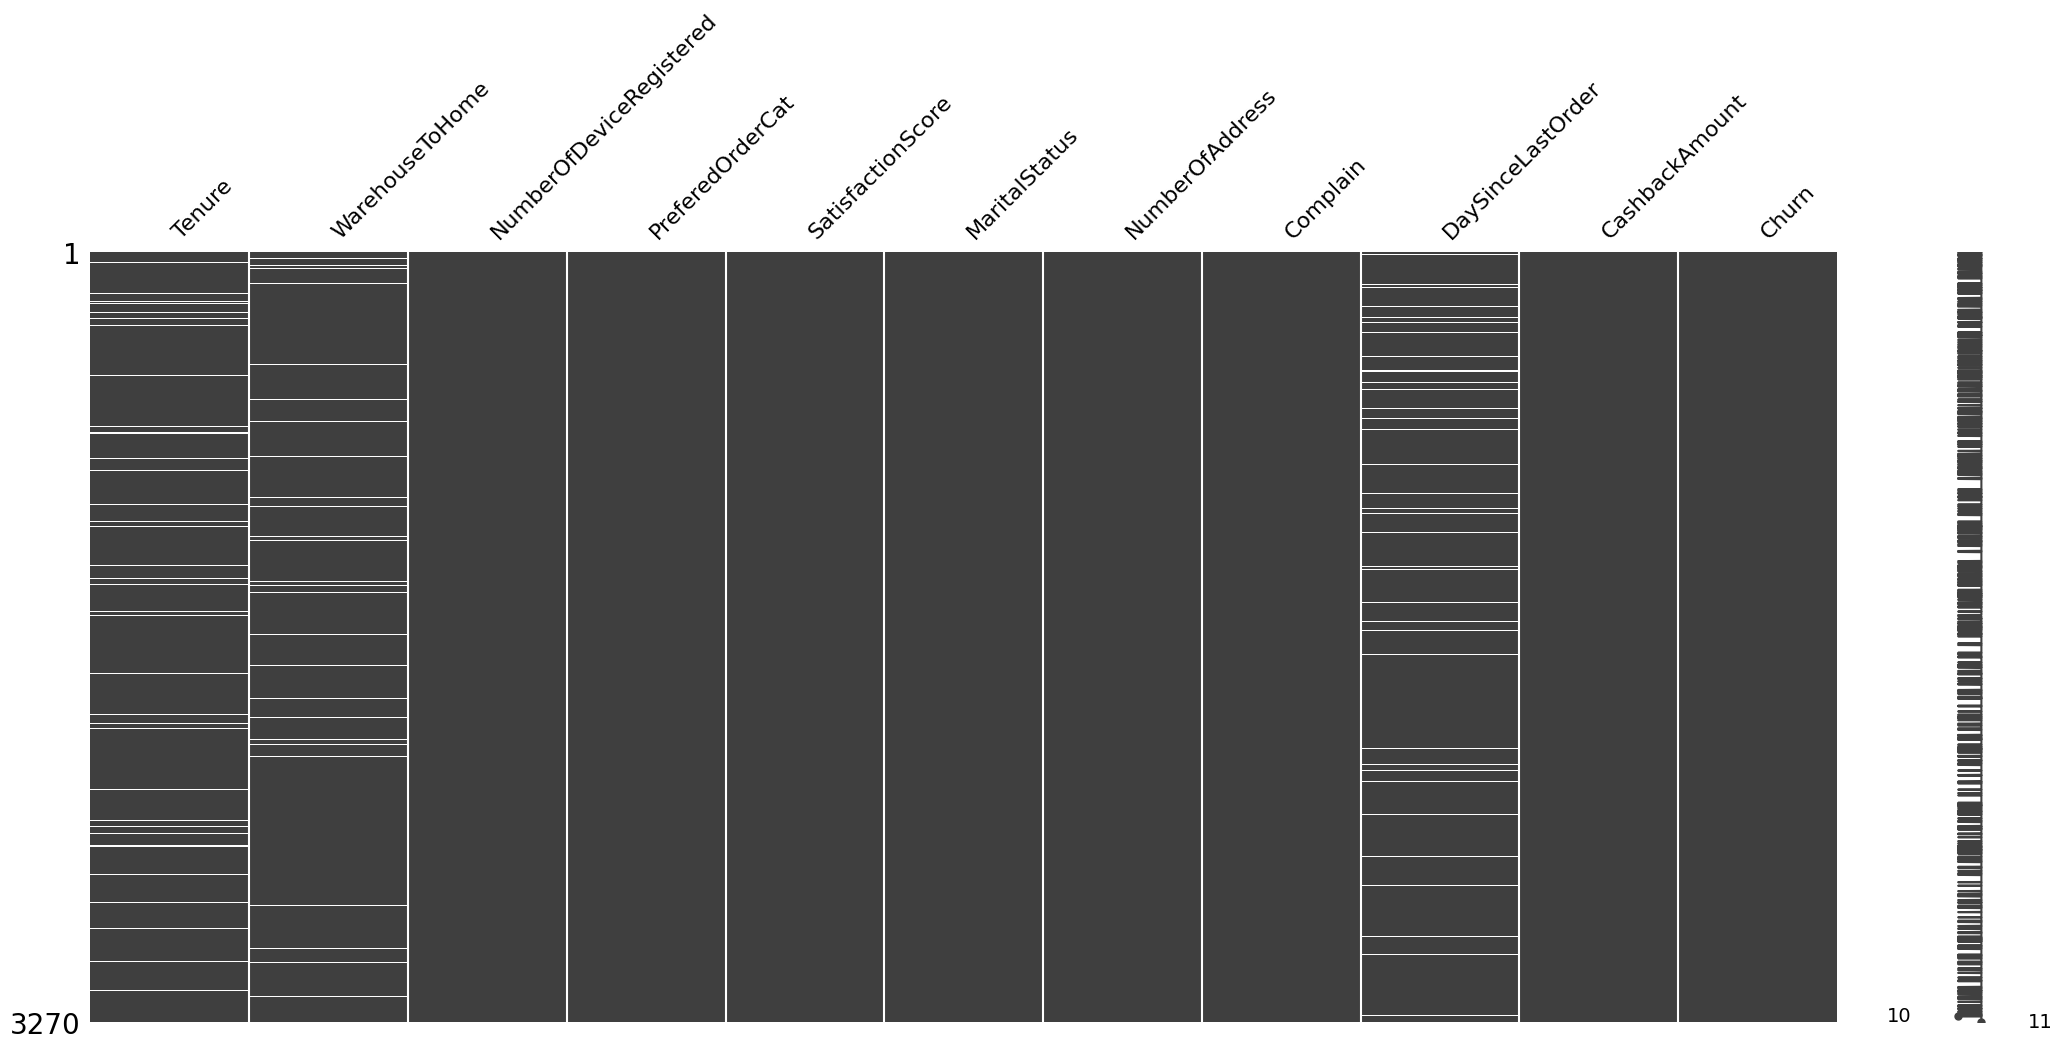

In [7]:
missingno.matrix(df)

Saat di tahap preprocessing nanti, saya akan membuatkan pipeline untuk 3 fitur (Tenure, WarehouseToHome, DaySinceLastOrder) untuk dilakukan imputer untuk mengisi missing value.

### Handling Outlier

#### Churn vs Tenure

<Axes: xlabel='Churn', ylabel='Tenure'>

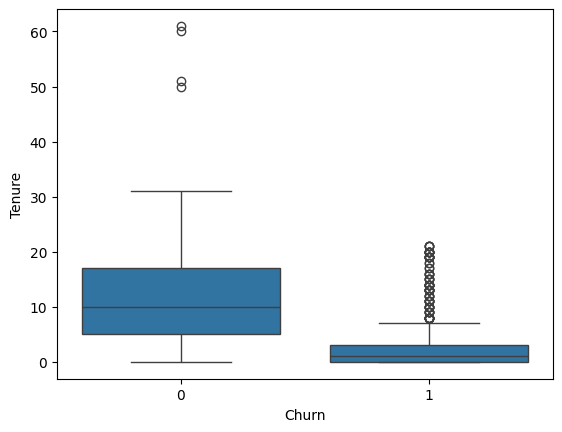

In [8]:
sns.boxplot(data=df, x='Churn', y='Tenure')

In [9]:
df[df['Tenure'] > 40]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
51,61.0,28.0,4,Grocery,1,Married,6,1,1.0,303.75,0
449,51.0,7.0,2,Laptop & Accessory,3,Divorced,2,0,9.0,174.00,0
1209,60.0,27.0,3,Grocery,1,Married,5,1,0.0,278.75,0
3778,50.0,6.0,1,Laptop & Accessory,3,Divorced,1,0,8.0,149.00,0


Karena hanya ada 4 pelanggan yang memiliki Tenure lebih dari 40, maka akan didrop.

In [10]:
df = df[(df['Tenure'] <= 40) | (df['Tenure'].isna())]

#### Churn vs WarehouseToHome

<Axes: xlabel='Churn', ylabel='WarehouseToHome'>

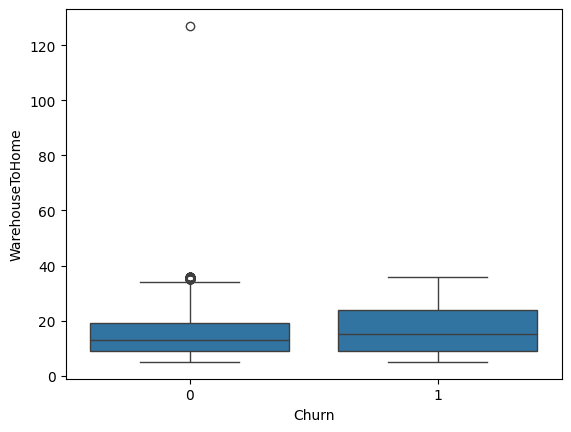

In [11]:
sns.boxplot(data=df, x='Churn', y='WarehouseToHome')

In [12]:
df[df['WarehouseToHome'] > 100]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2717,26.0,127.0,4,Mobile Phone,1,Married,4,0,1.0,159.82,0


Karena hanya ada 1 pelanggan yang jarak dari rumah ke gudang lebih dari 100 km, maka akan dihapus.

In [13]:
df = df[(df['WarehouseToHome'] <= 100) | (df['WarehouseToHome'].isna())]

#### Churn vs NumberOfDeviceRegistered

<Axes: xlabel='Churn', ylabel='NumberOfDeviceRegistered'>

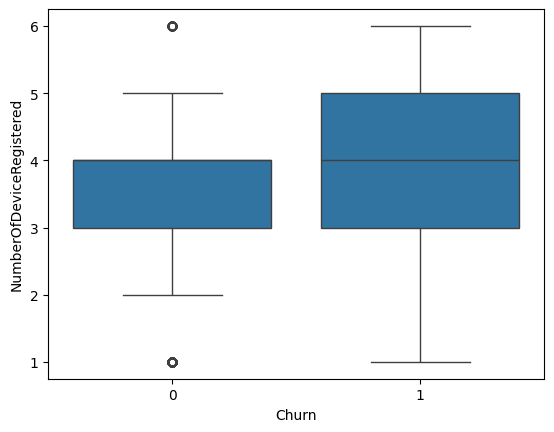

In [14]:
sns.boxplot(data=df, x='Churn', y='NumberOfDeviceRegistered')

In [15]:
((df['NumberOfDeviceRegistered'] > 5) & (df['Churn'] == 0)).sum()

59

In [16]:
((df['NumberOfDeviceRegistered'] < 2) & (df['Churn'] == 0)).sum()

122

Karena outlier di kolom NumberOfDeviceRegistered ini cukup banyak, maka tidak akan saya drop.

#### Churn vs SatisfactionScore

<Axes: xlabel='Churn', ylabel='SatisfactionScore'>

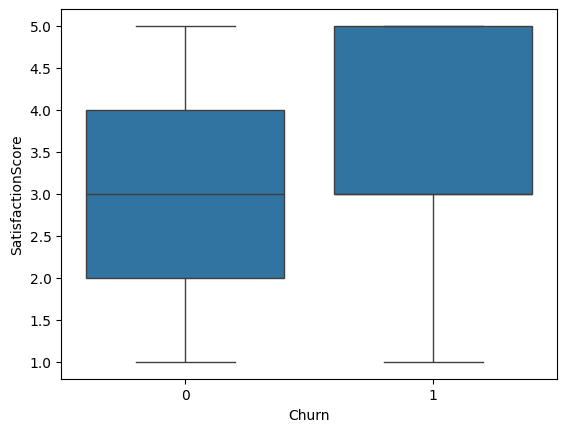

In [17]:
sns.boxplot(data=df, x='Churn', y='SatisfactionScore')

Tidak ada outlier, sehingga tidak dilakukan treatment apapun.

#### Churn vs NumberOfAddress

<Axes: xlabel='Churn', ylabel='NumberOfAddress'>

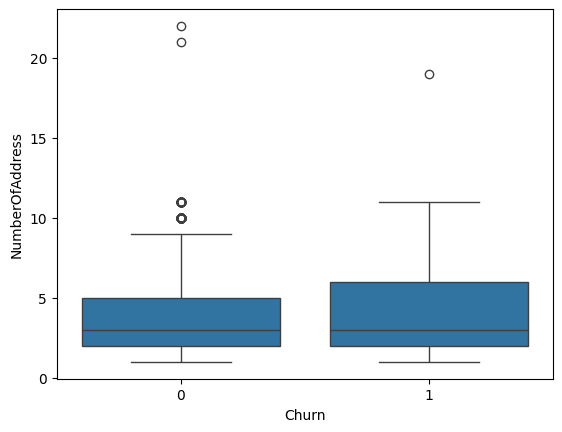

In [18]:
sns.boxplot(data=df, x='Churn', y='NumberOfAddress')

In [19]:
df[df['NumberOfAddress'] > 20]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2109,13.0,16.0,4,Laptop & Accessory,4,Single,22,0,4.0,192.82,0
3494,12.0,15.0,3,Laptop & Accessory,4,Single,21,0,3.0,167.82,0


Pelanggan yang memiliki NumberOfAddress lebih dari 20 akan saya drop.

In [20]:
df = df[(df['NumberOfAddress'] <= 20) | (df['NumberOfAddress'].isna())]

#### Churn vs Complain

<Axes: xlabel='Churn', ylabel='Complain'>

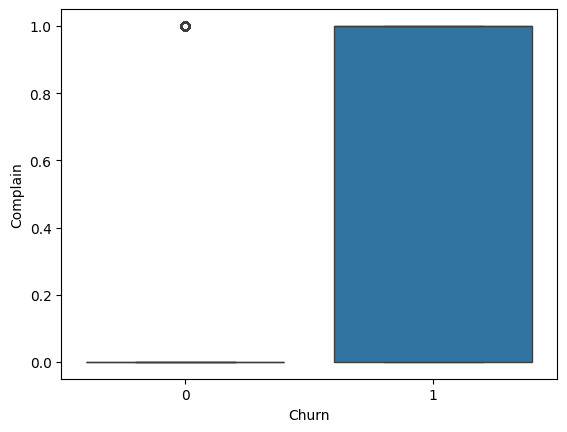

In [21]:
sns.boxplot(data=df, x='Churn', y='Complain')

In [22]:
((df['Complain'] == 1) & (df['Churn'] == 0)).sum()

626

Pelanggan yang mengajukan complain padahal dia loyal, tidak akan dihapus.

<Axes: xlabel='Churn', ylabel='Complain'>

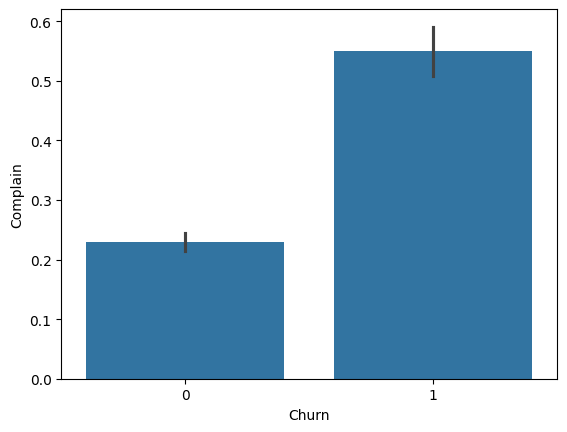

In [81]:
sns.barplot(data=df, x='Churn', y='Complain')

#### Churn vs DaySinceLastOrder

<Axes: xlabel='Churn', ylabel='DaySinceLastOrder'>

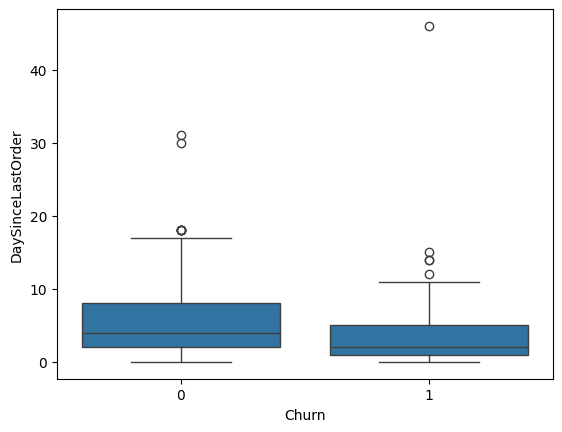

In [23]:
sns.boxplot(data=df, x='Churn', y='DaySinceLastOrder')

In [24]:
df[df['DaySinceLastOrder'] > 20]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
181,3.0,11.0,3,Mobile,5,Married,6,0,30.0,132.04,0
3591,0.0,6.0,4,Fashion,3,Married,6,0,46.0,206.09,1
3830,4.0,12.0,4,Mobile Phone,5,Married,7,0,31.0,157.04,0


Pelanggan yang memiliki DaySinceLastOrder yang lebih dari 20 akan saya drop.

In [25]:
df = df[(df['DaySinceLastOrder'] <= 20) | (df['DaySinceLastOrder'].isna())]

#### Churn vs CashbackAmount

<Axes: xlabel='Churn', ylabel='CashbackAmount'>

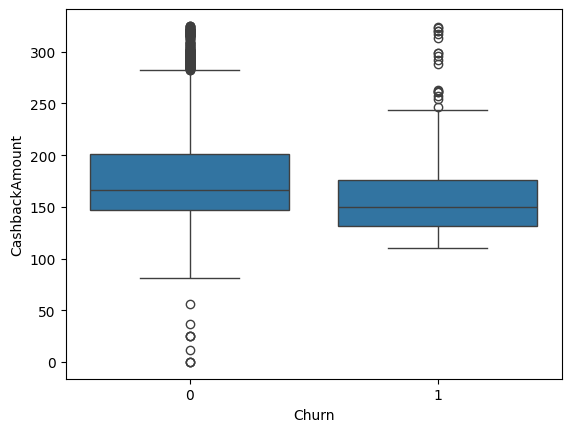

In [26]:
sns.boxplot(data=df, x='Churn', y='CashbackAmount')

Karena outlier pada kolom Cashbackamount terlalu banyak, maka tidak akan dilakukan treatment apapun.

array([[<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'WarehouseToHome'}>,
        <Axes: title={'center': 'NumberOfDeviceRegistered'}>],
       [<Axes: title={'center': 'SatisfactionScore'}>,
        <Axes: title={'center': 'NumberOfAddress'}>,
        <Axes: title={'center': 'Complain'}>],
       [<Axes: title={'center': 'DaySinceLastOrder'}>,
        <Axes: title={'center': 'CashbackAmount'}>,
        <Axes: title={'center': 'Churn'}>]], dtype=object)

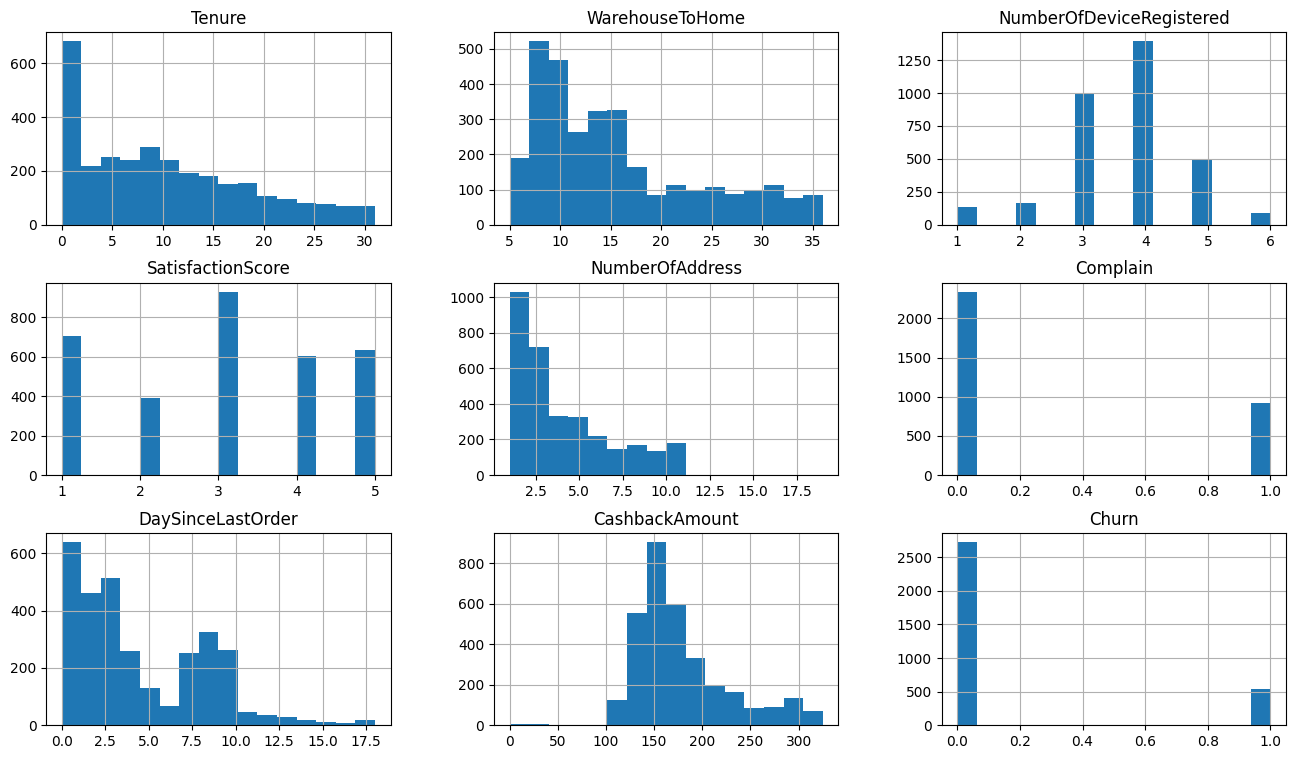

In [82]:
df.hist(bins=16, figsize=(16,9))

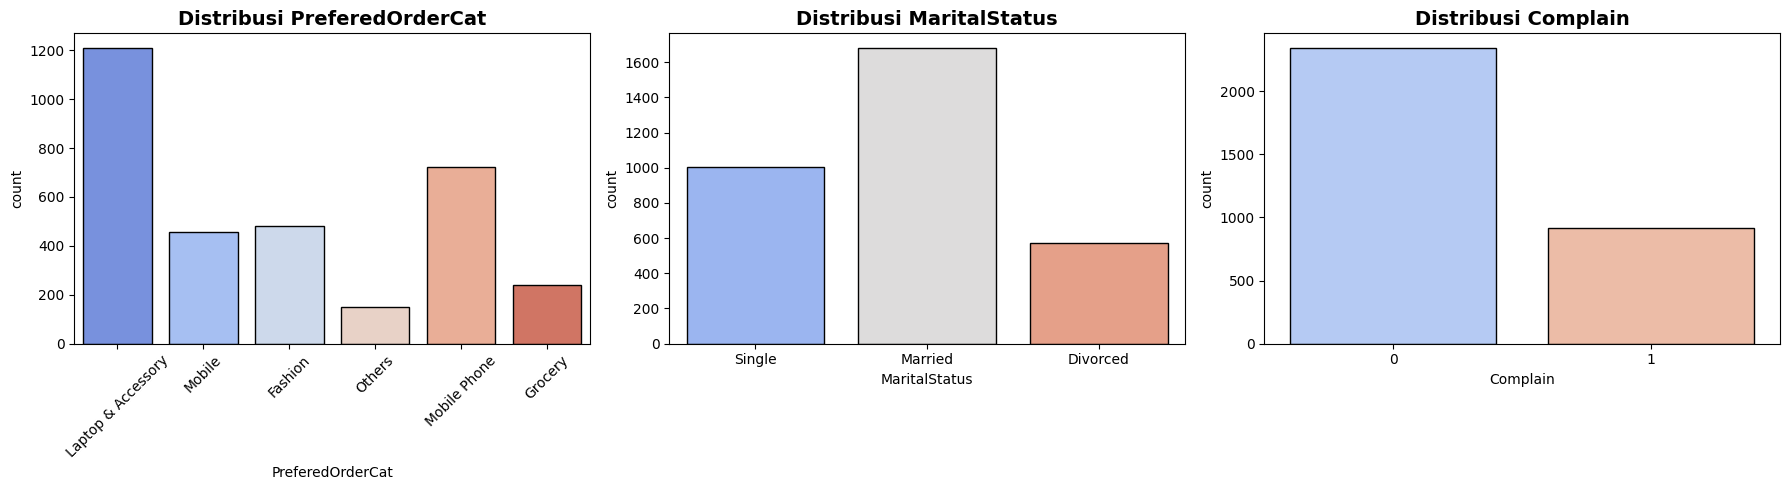

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot PreferedOrderCat
sns.countplot(
    x='PreferedOrderCat', 
    data=df, 
    palette='coolwarm', 
    ax=axes[0],
    edgecolor='black'
)
axes[0].set_title("Distribusi PreferedOrderCat", fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Plot MaritalStatus
sns.countplot(
    x='MaritalStatus', 
    data=df, 
    palette='coolwarm', 
    ax=axes[1],
    edgecolor='black'
)
axes[1].set_title("Distribusi MaritalStatus", fontsize=14, fontweight='bold')

# Plot Complain
sns.countplot(
    x='Complain', 
    data=df, 
    palette='coolwarm', 
    ax=axes[2],
    edgecolor='black'
)
axes[2].set_title("Distribusi Complain", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insight Distribusi Fitur Kategori

### 1. PreferedOrderCat
- Mayoritas pelanggan memilih kategori **Laptop & Accessory**, diikuti oleh **Mobile Phone**.
- Kategori **Others** dan **Grocery** jumlahnya jauh lebih sedikit → potensi untuk promosi atau bundling produk agar kategori ini lebih diminati.

### 2. MaritalStatus
- Sebagian besar pelanggan berstatus **Married**, diikuti oleh **Single** dan **Divorced**.
- Segmentasi kampanye dapat dibuat berdasarkan status pernikahan, misalnya promo keluarga untuk Married atau promo personal untuk Single.

### 3. Complain
- Lebih banyak pelanggan yang **tidak pernah complain** dibandingkan yang pernah complain.
- Namun, pelanggan yang pernah complain tetap perlu perhatian khusus agar tidak churn, misalnya melalui program customer recovery.

# Data Preparation

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3100 non-null   float64
 1   WarehouseToHome           3125 non-null   float64
 2   NumberOfDeviceRegistered  3260 non-null   int64  
 3   PreferedOrderCat          3260 non-null   object 
 4   SatisfactionScore         3260 non-null   int64  
 5   MaritalStatus             3260 non-null   object 
 6   NumberOfAddress           3260 non-null   int64  
 7   Complain                  3260 non-null   int64  
 8   DaySinceLastOrder         3079 non-null   float64
 9   CashbackAmount            3260 non-null   float64
 10  Churn                     3260 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 305.6+ KB


In [28]:
df.describe(include='object')

,PreferedOrderCat,MaritalStatus
count,3260,3260
unique,6,3
top,Laptop & Accessory,Married
freq,1209,1680


In [72]:
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3100.000000,3125.000000,3260.000000,3260.000000,3260.00000,3260.000000,3079.000000,3260.000000,3260.000000
mean,10.132903,15.478400,3.677914,3.020859,4.21135,0.281902,4.517051,177.372592,0.163497
std,8.499744,8.335971,1.017160,1.394833,2.59010,0.449995,3.561164,49.289877,0.369875
min,0.000000,5.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.00000,0.000000,2.000000,145.875000,0.000000
50%,9.000000,13.000000,4.000000,3.000000,3.00000,0.000000,3.000000,163.870000,0.000000
75%,16.000000,20.000000,4.000000,4.000000,6.00000,1.000000,7.000000,197.132500,0.000000
max,31.000000,36.000000,6.000000,5.000000,19.00000,1.000000,18.000000,324.990000,1.000000


## Cek Imbalance

In [29]:
(df['Churn'] == 0).sum()

2727

In [30]:
(df['Churn'] == 1).sum()

533

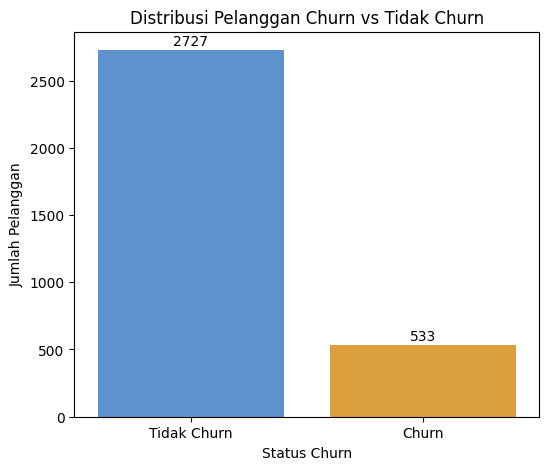

In [80]:
# Hitung jumlah churn dan non-churn
churn_counts = df['Churn'].value_counts().reset_index()
churn_counts.columns = ['Churn', 'Jumlah']

# Label mapping
label_map = {0: 'Tidak Churn', 1: 'Churn'}
churn_counts['Churn'] = churn_counts['Churn'].map(label_map)

# Plot barplot
plt.figure(figsize=(6, 5))
sns.barplot(
    data=churn_counts,
    x='Churn',
    y='Jumlah',
    palette=['#4A90E2', '#F5A623']
)

# Tambahkan label jumlah di atas bar
for i, val in enumerate(churn_counts['Jumlah']):
    plt.text(i, val + 10, str(val), ha='center', va='bottom', fontsize=10)

plt.title('Distribusi Pelanggan Churn vs Tidak Churn')
plt.ylabel('Jumlah Pelanggan')
plt.xlabel('Status Churn')
plt.show()

Dari total 3.260, terdapat 2.727 pelanggan No Churn dan terdapat 533 pelanggan yang Churn.

Karena data yang dimiliki tidak seimbang, maka akan dilakukan resampling. Ada 2 metode resampling yang akan saya gunakan dan tuning untuk mencari metode resampling terbaik. Yaitu, Random OverSampling (Menambah data pada kelas minoritas secara acak) dan SMOTEOverSampling (Menambah data pada kelas minoritas dengan interpolasi antara titik-titik terdekat). Disini saya tidak akan melakukan tuning untuk UnderSampling, karena jumlah kelas minoritas (533) terlalu sedikit dan dikhawatirkan akan terjadi underfitting dikarenakan kurangnya data yang dimiliki.

## Define X & y

In [31]:
X = df.drop(columns=['Churn'])
y = df['Churn']

## Data Splitting

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

## Data Preprocessing

- Imputer : Tenure, WarehouseToHome, DaySinceLastOrder
- Encoding : PreferedOrderCat, MaritalStatus
- Scaling : Tenure, WarehouseToHome, DaySinceLastOrder, PreferedOrderCat, MaritalStatus, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, Complain, CashbackAmount

In [33]:
pipe_ImputeScaling = Pipeline([
    ('simImput', SimpleImputer(strategy='median')),
    ('robScaler', RobustScaler())
])

pipe_EncodeScaling = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('robScaler', RobustScaler())
])

In [34]:
transformer = ColumnTransformer([
    ('pipe_impute', pipe_ImputeScaling, ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']),
    ('pipe_encoding', pipe_EncodeScaling, ['PreferedOrderCat', 'MaritalStatus']),
    ('robScaler', RobustScaler(), ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount'] )
], remainder='passthrough')

In [35]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_impute',
                                 Pipeline(steps=[('simImput',
                                                  SimpleImputer(strategy='median')),
                                                 ('robScaler',
                                                  RobustScaler())]),
                                 ['Tenure', 'WarehouseToHome',
                                  'DaySinceLastOrder']),
                                ('pipe_encoding',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('robScaler',
                                                  RobustScaler())]),
                                 ['PreferedOrderCat', 'MaritalStatus']),
                                ('robScaler', RobustScaler(),
                                 ['NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'Complain', 'CashbackAmount'])])

# Modeling

## Cross-Validation Modeling Dan Resampling

In [36]:
f3_scorer = make_scorer(fbeta_score, beta=3)


logreg = LogisticRegression(random_state=0, class_weight='balanced')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, class_weight='balanced') 
rf = RandomForestClassifier(random_state=0, class_weight='balanced') 
ada = AdaBoostClassifier(tree, random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
xgbc = XGBClassifier(random_state=0, verbosity=0, class_weight='balanced')


metode_Resampling = [None, SMOTE(random_state=42), RandomOverSampler(random_state=42)]
list_model = [logreg, knn, tree, rf, ada, gbc, xgbc]

algoritma = []
hasil_cv = []
metode_list = []

for model in list_model:
    for metode in metode_Resampling:
        steps = [('preprocessing', transformer)]
        
        # Tambahkan step resampling kalau tidak None
        if metode is not None:
            steps.append(('resampling', metode))
        
        steps.append(('modeling', model))
        
        pipe_model = ImbPipeline(steps)
        
        scores = cross_val_score(pipe_model, X_train, y_train, cv=5, scoring=f3_scorer)
        
        algoritma.append(model.__class__.__name__)
        hasil_cv.append(scores)
        metode_list.append('None' if metode is None else metode.__class__.__name__)



In [37]:
# Buat DataFrame ringkasan
df_cv = pd.DataFrame()
df_cv['Algoritma'] = algoritma
df_cv['Resampling'] = metode_list
df_cv['Score'] = hasil_cv
df_cv['Mean'] = [np.mean(s) for s in hasil_cv]
df_cv['Std'] = [np.std(s) for s in hasil_cv]

df_cv

,Algoritma,Resampling,Score,Mean,Std
0,LogisticRegression,None,"[0.7675675675675675, 0.6427015250544662, 0.738...",0.722757,0.056468
1,LogisticRegression,SMOTE,"[0.7700650759219091, 0.6413043478260868, 0.729...",0.720299,0.054321
2,LogisticRegression,RandomOverSampler,"[0.7526881720430106, 0.6202393906420021, 0.719...",0.713086,0.062800
3,KNeighborsClassifier,None,"[0.33707865168539325, 0.3117206982543641, 0.39...",0.363640,0.034900
4,KNeighborsClassifier,SMOTE,"[0.7290533188248095, 0.6762749445676275, 0.647...",0.696263,0.031552
5,KNeighborsClassifier,RandomOverSampler,"[0.7314410480349345, 0.6896551724137931, 0.652...",0.703378,0.038473
6,DecisionTreeClassifier,None,"[0.6168446026097272, 0.5721096543504172, 0.584...",0.599257,0.017838
7,DecisionTreeClassifier,SMOTE,"[0.6580493537015276, 0.5484247374562428, 0.652...",0.642154,0.079537
8,DecisionTreeClassifier,RandomOverSampler,"[0.590318772136954, 0.5778301886792453, 0.5342...",0.575029,0.026839
9,RandomForestClassifier,None,"[0.48327137546468396, 0.4551045510455105, 0.48...",0.493760,0.038428


Model terbaik adalah GradientBoosting dan menggunakan RandomOverSampler yang mendapatkan mean F-3 Score tertinggi (75,5%) dan cukup stabil dengan Standar Deviasi yang masih relatif rendah (0,034)

## Feature Selection

In [38]:
# Model awal (tanpa feature selection)
pipe = ImbPipeline([
    ("preprocess", transformer),
    ("resampling", RandomOverSampler(random_state=42)),
    ("model", GradientBoostingClassifier(random_state=0))
])

pipe.fit(X_train, y_train)

# Ambil feature importance dari model dalam pipeline
model_gb = pipe.named_steps["model"]
feature_importance = model_gb.feature_importances_

In [39]:
# Ambil nama fitur setelah preprocessing
feature_names = pipe.named_steps["preprocess"].get_feature_names_out(input_features=X_train.columns)

print(feature_names)
print(len(feature_names), "fitur total")

['pipe_impute__Tenure' 'pipe_impute__WarehouseToHome'
 'pipe_impute__DaySinceLastOrder'
 'pipe_encoding__PreferedOrderCat_Grocery'
 'pipe_encoding__PreferedOrderCat_Laptop & Accessory'
 'pipe_encoding__PreferedOrderCat_Mobile'
 'pipe_encoding__PreferedOrderCat_Mobile Phone'
 'pipe_encoding__PreferedOrderCat_Others'
 'pipe_encoding__MaritalStatus_Married'
 'pipe_encoding__MaritalStatus_Single'
 'robScaler__NumberOfDeviceRegistered' 'robScaler__SatisfactionScore'
 'robScaler__NumberOfAddress' 'robScaler__Complain'
 'robScaler__CashbackAmount']
15 fitur total


In [40]:
gb_model = pipe.named_steps["model"]
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": gb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

                                              Feature  Importance
0                                 pipe_impute__Tenure    0.492018
14                          robScaler__CashbackAmount    0.169176
13                                robScaler__Complain    0.097268
12                         robScaler__NumberOfAddress    0.057664
11                       robScaler__SatisfactionScore    0.047976
2                      pipe_impute__DaySinceLastOrder    0.044931
1                        pipe_impute__WarehouseToHome    0.028062
10                robScaler__NumberOfDeviceRegistered    0.015391
9                 pipe_encoding__MaritalStatus_Single    0.015154
4   pipe_encoding__PreferedOrderCat_Laptop & Acces...    0.013028
8                pipe_encoding__MaritalStatus_Married    0.008595
7              pipe_encoding__PreferedOrderCat_Others    0.006928
3             pipe_encoding__PreferedOrderCat_Grocery    0.002877
6        pipe_encoding__PreferedOrderCat_Mobile Phone    0.000931
5         

Saya akan melakukan pengujian menggunakan 10 fitur teratas, alasannya adalah karena 10 fitur saja sudah cukup mewakili 98% dari seluruh informasi data.

In [41]:
# List untuk simpan hasil
algoritma = []
metode_list = []
hasil_cv = []

# Pipeline
pipe_gbc_ros = ImbPipeline([
    ('preprocessing', transformer),
    ('resampling', RandomOverSampler(random_state=42)),
    ('select', SelectKBest(score_func=f_classif, k=10)),
    ('modeling', GradientBoostingClassifier(random_state=0))
])

# Cross-validation
scores = cross_val_score(pipe_gbc_ros, X_train, y_train, cv=5, scoring=f3_scorer)

# Simpan hasil ke list
algoritma.append('GradientBoostingClassifier')
metode_list.append('RandomOverSampler')
hasil_cv.append(scores)

# Buat DataFrame ringkasan
df_cv = pd.DataFrame({
    'Algoritma': algoritma,
    'Resampling': metode_list,
    'Score': hasil_cv,
    'Mean': [np.mean(s) for s in hasil_cv],
    'Std': [np.std(s) for s in hasil_cv]
})

df_cv

,Algoritma,Resampling,Score,Mean,Std
0,GradientBoostingClassifier,RandomOverSampler,"[0.7829977628635347, 0.7222222222222222, 0.704...",0.739597,0.047232


Disini saya memutuskan untuk menggunakan seluruh fitur saja karena 15 fitur tergolong masih sedikit dan hasil yang didapatkan lebih baik ketimbang menggunakan 10 fitur saja.

## HyperParameter Tuning

In [42]:
# Pipeline preprocessing + resampling + model
pipe_gbc = ImbPipeline([
    ('preprocessing', transformer),
    ('resampling', RandomOverSampler(random_state=42)),
    ('modeling', GradientBoostingClassifier(random_state=0))
])

# Parameter Grid untuk Gradient Boosting
param_grid_gbc = {
    'modeling__n_estimators': [100, 200],
    'modeling__learning_rate': [0.05, 0.1],
    'modeling__max_depth': [3, 5],
    'modeling__min_samples_split': [2, 5],
    'modeling__min_samples_leaf': [1, 2],
    'modeling__subsample': [0.8, 1.0]
}

# GridSearchCV
grid_gbc = GridSearchCV(
    estimator=pipe_gbc,
    param_grid=param_grid_gbc,
    cv=5,
    scoring=f3_scorer, 
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_gbc.fit(X_train, y_train)

print("Best Parameters:", grid_gbc.best_params_)
print("Best CV Score:", grid_gbc.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'modeling__learning_rate': 0.1, 'modeling__max_depth': 3, 'modeling__min_samples_leaf': 2, 'modeling__min_samples_split': 2, 'modeling__n_estimators': 100, 'modeling__subsample': 0.8}
Best CV Score: 0.7612587946103982


In [43]:
pd.DataFrame(grid_gbc.cv_results_).sort_values(by='rank_test_score').head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__learning_rate,param_modeling__max_depth,param_modeling__min_samples_leaf,param_modeling__min_samples_split,param_modeling__n_estimators,param_modeling__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.338301,0.010865,0.005474,0.002027,0.1,3,2,2,100,0.8,"{'modeling__learning_rate': 0.1, 'modeling__ma...",0.787671,0.733634,0.752212,0.715096,0.817680,0.761259,0.037032,1
32,0.350069,0.007087,0.004029,0.001067,0.1,3,1,2,100,0.8,"{'modeling__learning_rate': 0.1, 'modeling__ma...",0.764840,0.756208,0.753045,0.706956,0.816777,0.759565,0.034993,2
4,0.343243,0.022511,0.007456,0.003082,0.05,3,1,5,100,0.8,"{'modeling__learning_rate': 0.05, 'modeling__m...",0.780543,0.751121,0.733042,0.711061,0.818777,0.758909,0.037607,3
15,0.785010,0.022779,0.006350,0.002655,0.05,3,2,5,200,1.0,"{'modeling__learning_rate': 0.05, 'modeling__m...",0.756014,0.751121,0.740331,0.717540,0.828729,0.758747,0.037417,4
0,0.356199,0.016058,0.007144,0.003769,0.05,3,1,2,100,0.8,"{'modeling__learning_rate': 0.05, 'modeling__m...",0.780543,0.750280,0.733042,0.709459,0.817884,0.758242,0.037770,5


Setelah melakukan tuning pada model GradientBoosting, F3-Score meningkat yang awalnya 75,5% menjadi 76,1% (terjadi peningkatan sebesar 0,6%).

# Evaluation

### Uji ke test set

In [ ]:
# Sebelum Tuning
pipe_gbc = ImbPipeline([
    ('preprocessing', transformer),
    ('resampling', RandomOverSampler(random_state=42)),
    ('modeling', GradientBoostingClassifier(random_state=0))
])

# fitting
pipe_gbc.fit(X_train, y_train)

# predict
y_pred = pipe_gbc.predict(X_test)

# score
f3score_gbc_benchmark = fbeta_score(y_test, y_pred, beta=3)

# Setelah Tuning
# best model
gbc_tuning = grid_gbc.best_estimator_

# fitting
gbc_tuning.fit(X_train, y_train)

# predict
y_pred_gbc_tuning = gbc_tuning.predict(X_test)

# score
f3score_gbc_tuning = fbeta_score(y_test, y_pred_gbc_tuning, beta=3)

print(f3score_gbc_benchmark, 'Gboost Benchmark')
print(f3score_gbc_tuning, 'Gboost Tuning')


0.8676599474145485 Gboost Benchmark
0.8508771929824561 Gboost Tuning


Pada saat melakukan prediksi ke test set, terjadi penurunan saat menggunakan tuning yang awal nya 86,7% menjadi 85,08%. Maka di sini saya akan menggunakan base model saja.

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       545
           1       0.56      0.93      0.69       107

    accuracy                           0.87       652
   macro avg       0.77      0.89      0.80       652
weighted avg       0.91      0.87      0.88       652



## Tuning Threshold

In [46]:
listThreshold = np.arange(0.01, 1.00, 0.01)
listF3 = []

y_pred_proba = pipe_gbc.predict_proba(X_test)[:, 1]

for i in listThreshold:
    y_pred_class = np.where(y_pred_proba > i, 1, 0)
    score = fbeta_score(y_test, y_pred_class, beta=3)
    listF3.append(score)

In [47]:
df_f3 = pd.DataFrame({
    'Threshold': listThreshold,
    'F3_Score': listF3
})

df_f3.head()

,Threshold,F3_Score
0,0.01,0.663360
1,0.02,0.672533
2,0.03,0.685458
3,0.04,0.700262
4,0.05,0.707204


In [48]:
df_f3.sort_values(by='F3_Score', ascending=False)

,Threshold,F3_Score
53,0.54,0.875332
52,0.53,0.873786
37,0.38,0.872881
51,0.52,0.871479
36,0.37,0.871404
...,...,...
94,0.95,0.133060
95,0.96,0.092593
96,0.97,0.051653
97,0.98,0.031056


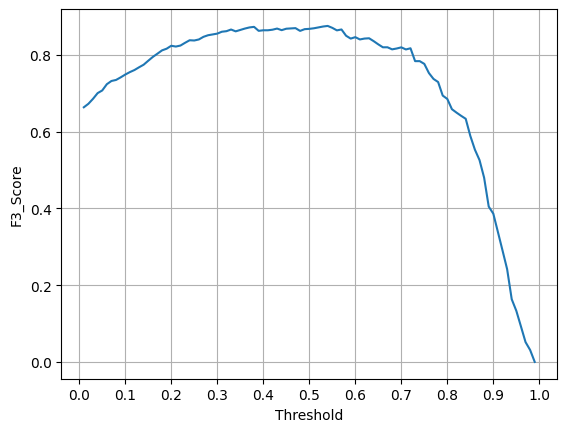

In [49]:
plt.Figure(figsize=(12,4))
sns.lineplot(data=df_f3, x = 'Threshold', y = 'F3_Score')
plt.xticks(np.arange(0,1.1,0.1))
plt.grid()

Nilai F3-Score paling tinggi adalah saat Threshold nya di 0,54

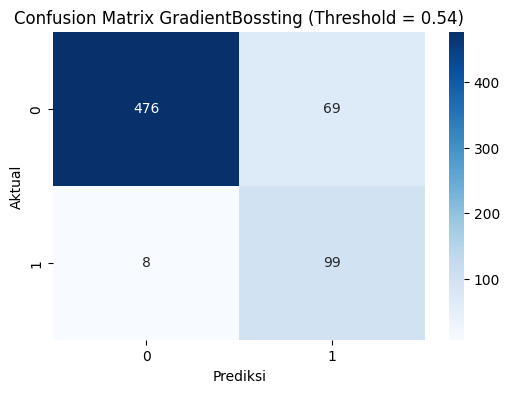

In [50]:
# Prediksi probabilitas churn (kelas 1)
y_pred_proba = pipe_gbc.predict_proba(X_test)[:, 1]

# Ubah ke prediksi kelas dengan threshold 0.54
threshold = 0.54
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title(f"Confusion Matrix GradientBossting (Threshold = {threshold})")
plt.show()

# Save Model

In [70]:
import joblib

# Buat dictionary yang menyimpan model dan threshold
model_package = {
    "model": pipe_gbc,
    "threshold": 0.54
}

# Simpan ke file
joblib.dump(model_package, "pipe_gbc_threshold054.joblib")
print("Model + threshold berhasil disimpan sebagai pipe_gbc_threshold054.joblib")

Model + threshold berhasil disimpan sebagai pipe_gbc_threshold054.joblib


In [71]:
# Load kembali
loaded_package = joblib.load("pipe_gbc_threshold054.joblib")

# Ambil model dan threshold
pipe_gbc_loaded = loaded_package["model"]
threshold_loaded = loaded_package["threshold"]

# Prediksi probabilitas dan terapkan threshold
y_pred_proba = pipe_gbc_loaded.predict_proba(X_test)[:, 1]
y_pred_loaded = (y_pred_proba > threshold_loaded).astype(int)

## Prediksi ke data baru (dummy)

In [76]:
new_cust = pd.DataFrame({
    'Tenure': [5, 12, 8, 20, 3, 1],
    'WarehouseToHome': [10.0, 25.0, 15.0, 30.0, 8.0, 40.0],
    'NumberOfDeviceRegistered': [2, 4, 3, 5, 1, 1],
    'PreferedOrderCat': [
        'Laptop & Accessory', 
        'Mobile', 
        'Grocery', 
        'Fashion', 
        'Others',
        'Laptop & Accesory'
    ],
    'SatisfactionScore': [4, 2, 5, 3, 1, 1],
    'MaritalStatus': ['Married', 'Single', 'Divorced', 'Married', 'Single', 'Married'],
    'NumberOfAddress': [3, 5, 2, 6, 1, 7],
    'Complain': [0, 1, 0, 0, 1, 1],
    'DaySinceLastOrder': [2.0, 5.0, 1.0, 8.0, 3.0, 18.0],
    'CashbackAmount': [150.50, 200.00, 175.75, 160.00, 145.00, 0.00]
})

new_cust

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,5,10.0,2,Laptop & Accessory,4,Married,3,0,2.0,150.50
1,12,25.0,4,Mobile,2,Single,5,1,5.0,200.00
2,8,15.0,3,Grocery,5,Divorced,2,0,1.0,175.75
3,20,30.0,5,Fashion,3,Married,6,0,8.0,160.00
4,3,8.0,1,Others,1,Single,1,1,3.0,145.00
5,1,40.0,1,Laptop & Accesory,1,Married,7,1,18.0,0.00


In [77]:
y_pred_proba_new = pipe_gbc_loaded.predict_proba(new_cust)[:, 1]

# Terapkan threshold
y_pred_new = (y_pred_proba_new > threshold_loaded).astype(int)
# Gabungkan hasil dengan data
hasil_prediksi = pd.DataFrame()
hasil_prediksi['Prediksi_Churn'] = y_pred_new
hasil_prediksi['Prob_Churn'] = y_pred_proba_new
hasil_prediksi

,Prediksi_Churn,Prob_Churn
0,0,0.023105
1,0,0.381773
2,0,0.177685
3,0,0.068713
4,0,0.213118
5,1,0.632266


# Interpretasi dengan Explainable AI

In [52]:
import shap

In [53]:
# ambil model dan data dari pipeline
my_model = pipe_gbc[-1]
my_data = pipe_gbc[0].transform(X_train)

# my_model, my_data

In [54]:
# define explainer
explainer_shap = shap.TreeExplainer(
    model= my_model,
    data= my_data,
    # feature_dependence= 'independent',
    # model_output= 'probability'
)

explainer_shap

In [55]:
# hitung shap value untuk tiap baris di data train
shap_values = explainer_shap.shap_values(my_data)
shap_values

array([[ 0.02610558,  0.29115628,  0.07021114, ...,  0.46615595,
        -0.47762317, -0.38423754],
       [-0.45168217, -0.05074897, -0.49074212, ..., -0.00429196,
        -0.30806842, -0.10158173],
       [ 0.02311023,  0.48402628,  0.13275203, ...,  0.00811586,
         0.99506364,  0.24364837],
       ...,
       [-0.1620821 ,  0.37108807,  0.46236118, ...,  0.05242113,
         1.14506197,  0.07803477],
       [-0.29106695, -0.04855346, -0.06995612, ..., -0.73636938,
        -0.42171918,  0.27461535],
       [-0.35006934,  0.08108495, -0.22499019, ..., -0.50566201,
        -0.34728872,  0.17616884]])

In [56]:
list_feat = pipe_gbc.named_steps['preprocessing'].get_feature_names_out()

feat = [i.split("__")[1] for i in list_feat] 
feat

['Tenure',
 'WarehouseToHome',
 'DaySinceLastOrder',
 'PreferedOrderCat_Grocery',
 'PreferedOrderCat_Laptop & Accessory',
 'PreferedOrderCat_Mobile',
 'PreferedOrderCat_Mobile Phone',
 'PreferedOrderCat_Others',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain',
 'CashbackAmount']

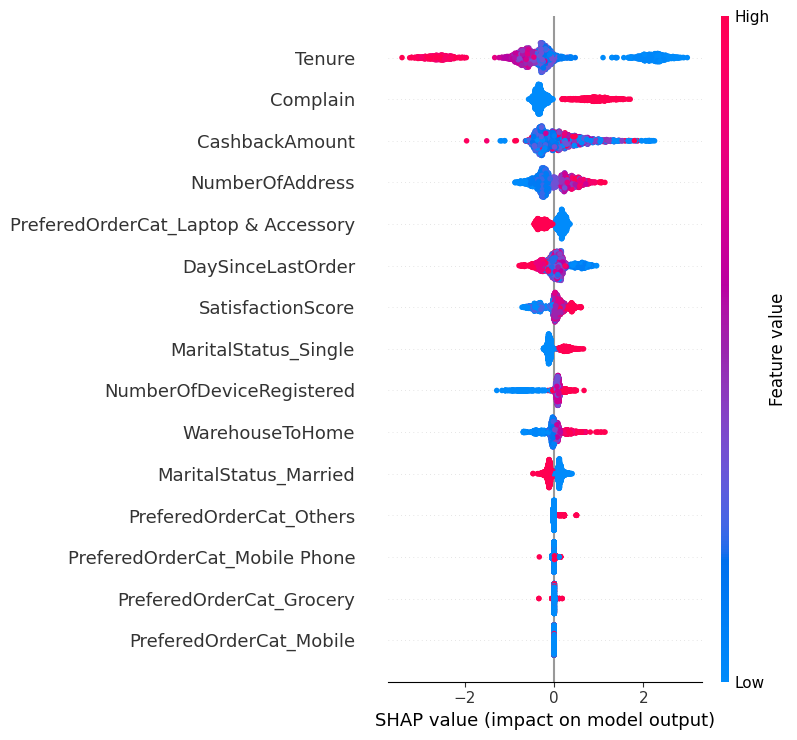

In [57]:
# tampilkan dalam bentuk plot                                 
shap.summary_plot(shap_values, my_data, feature_names=feat)

## Insight Feature Importance (SHAP)

- **Tenure** :  
  - Nilai Tenure yang rendah → probability churn **tinggi**  
  - Nilai Tenure yang tinggi → probability churn **rendah**  

- **Complain** :  
  - Pernah complain (nilai tinggi) → probability churn **tinggi**  
  - Tidak pernah complain (nilai rendah) → probability churn **rendah**  

- **CashbackAmount** :  
  - Cashback rendah → probability churn **tinggi**  
  - Cashback tinggi → probability churn **rendah**  

- **NumberOfAddress** :  
  - Jumlah alamat tinggi → probability churn **tinggi**  
  - Jumlah alamat rendah → probability churn **rendah**  

- **PreferedOrderCat_Laptop & Accessory** :  
  - Preferensi kategori ini (nilai tinggi) → probability churn **tinggi**  
  - Tidak memilih kategori ini (nilai rendah) → probability churn **rendah**  

- **DaySinceLastOrder** :  
  - Nilai tinggi → probability churn **tinggi**  
  - Nilai rendah → probability churn **rendah**  

- **SatisfactionScore** :  
  - Skor rendah → probability churn **tinggi**  
  - Skor tinggi → probability churn **rendah**  

- **MaritalStatus_Single** :  
  - Single → probability churn **rendah**  
  - Bukan single → probability churn **tinggi**  

- **NumberOfDeviceRegistered** :  
  - Nilai rendah → probability churn sedikit lebih tinggi  
  - Nilai tinggi → probability churn **rendah**  

- **WarehouseToHome** :  
  - Nilai tinggi → probability churn **tinggi**  
  - Nilai rendah → probability churn **rendah**  

- **MaritalStatus_Married** :  
  - Married → probability churn **tinggi**  
  - Bukan married → probability churn **rendah**  

- **PreferedOrderCat_Others** :  
  - Memilih kategori ini → probability churn sedikit meningkat  
  - Tidak memilih kategori ini → probability churn sedikit menurun  

- **PreferedOrderCat_Mobile Phone** :  
  - Memilih kategori ini → probability churn sedikit meningkat  
  - Tidak memilih kategori ini → probability churn sedikit menurun  

- **PreferedOrderCat_Grocery** :  
  - Memilih kategori ini → probability churn sedikit menurun  
  - Tidak memilih kategori ini → probability churn sedikit meningkat  

- **PreferedOrderCat_Mobile** :  
  - Memilih kategori ini → probability churn sedikit meningkat  
  - Tidak memilih kategori ini → probability churn sedikit menurun  

In [58]:
X_test.iloc[[1]]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
1763,20.0,9.0,4,Grocery,3,Married,8,0,2.0,303.61


In [59]:
y_test.iloc[[1]]

1763    0
Name: Churn, dtype: int64

In [60]:
shap.initjs()

In [61]:
def shap_plot(index, model, dataframe):
    
    # Membuat objek explainer untuk model tree-based (misalnya XGBoost, LightGBM, RandomForest)
    explainerModel = shap.TreeExplainer(model)

    # Hitung SHAP values untuk seluruh data dalam dataframe
    # shap_values_Model bentuknya array [n_samples, n_features]   
    shap_values_Model = explainerModel.shap_values(dataframe)
    
    # Tampilkan force plot untuk 1 baris data tertentu   
    p = shap.force_plot(
    explainerModel.expected_value,
    shap_values_Model[index],
    dataframe.iloc[[index]]
)            # output dalam bentuk gambar statis (bisa tampil di VS Code Jupyter)
    

    return(p)

In [62]:
# hanya menerima bentuk dataframe
X_test_prep = pd.DataFrame(pipe_gbc[0].transform(X_test), columns=feat)
X_test_prep.head()

,Tenure,WarehouseToHome,DaySinceLastOrder,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount
0,-0.230769,-0.363636,-0.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.25,1.0,-0.668189
1,0.846154,-0.363636,-0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.25,0.0,2.653154
2,-0.230769,-0.454545,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,-0.25,0.0,-0.536683
3,-0.615385,-0.181818,0.2,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.00,1.0,0.046056
4,0.923077,-0.363636,-0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,2.00,1.0,-0.293082


In [63]:
# Lets compare with the real result
print(f"The prediction must predict this customers {('Churn' if y_test.iloc[1] == 1 else 'Not Churn')} --> (This is y_test)")

shap_plot(
    index= 1, 
    model= my_model, 
    dataframe= X_test_prep
)


The prediction must predict this customers Not Churn --> (This is y_test)


In [64]:
import lime

In [65]:
from lime import lime_tabular

In [66]:
# define explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data= my_data,
    feature_names= feat,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

ML predict this passenger is: Not Churn (This is from y_test)


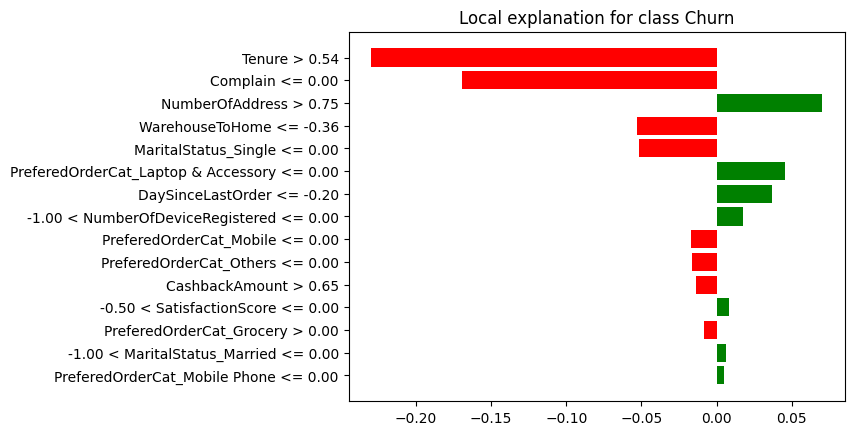

In [67]:
# Try to index 0 of X_test
# Lets compare with the real result
print(f"ML predict this passenger is: {('Churn' if y_test.iloc[0] == 1 else 'Not Churn')} (This is from y_test)")

# pilih baris data (customer ke-0) yang mau dijelaskan
index_customer = 1

# LIME akan menjelaskan prediksi model untuk 1 baris data
exp = explainer_lime.explain_instance(
    data_row= X_test_prep.iloc[index_customer], # ambil 1 row data input 
    predict_fn = my_model.predict_proba,        # fungsi prediksi yang dipakai LIME, harus probabilitas (bukan class)
    num_features= len(feat)                     # jumlah fitur yang ingin ditampilkan di penjelasan
)

exp.as_pyplot_figure()
plt.show()

In [68]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[0] == 1 else 'Not Churn')} --> from y_test")

exp = explainer_lime.explain_instance(
    data_row= X_test_prep.iloc[index_customer], 
    predict_fn= my_model.predict_proba
)

exp.show_in_notebook(show_table=True)

The prediction must predict this passenger is: Not Churn --> from y_test


# Conclusion

## Analisis Biaya Setelah Menggunakan Machine Learning

### **Asumsi Biaya**
- **Acquisition cost (A)** = Rp 150.000 / pelanggan baru (FN)  
- **Retention cost (R)** = Rp 20.000 / pelanggan yang diberi treatment (FP + TP)  

---

### **Confusion Matrix Model (Threshold = 0.54)**  
| Aktual \ Prediksi | 0 (No Churn) | 1 (Churn) |
|-------------------|--------------|-----------|
| **0** (No Churn)  | TN = 476     | FP = 69   |
| **1** (Churn)     | FN = 8       | TP = 99   |

---

### **1. Biaya Retention**  
Retention cost yang tidak diperlukan  

69 x Rp20.000 = Rp1.380.000


---

### **2. Biaya Acquisition**  
Acquisition diberikan ke pelanggan churn yang tidak di-treatment (**FN**)  

8 x Rp150.000 = Rp1.200.000


---

### **3. Total Biaya Setelah ML**  

Rp1.380.000 + Rp1.200.000 = Rp2.580.000


---

### **Perbandingan Biaya**
| Skenario                   | Total Biaya         | Selisih Hemat dibanding ML |
|----------------------------|--------------------:|---------------------------:|
| **Treat All**              | Rp 13.080.000       | Rp 10.500.000               |
| **Treat None**             | Rp 20.250.000       | Rp 17.670.000               |
| **Machine Learning (0.54)**| **Rp 2.580.000**    | –                           |

---

**Kesimpulan:**  
Menggunakan model ML dengan threshold 0,54 dapat menghemat biaya **Rp 10,05 juta** dibanding Treat All, dan **Rp 17,67 juta** dibanding Treat None.

# Recommendations

1. **Tenure rendah → risiko churn tinggi**  
   - Buat program onboarding yang lebih engaging (email welcome series, edukasi fitur, promo khusus bulan pertama).  
   - Berikan loyalty bonus setelah melewati 3–6 bulan pertama untuk mengurangi risiko churn di awal.  

2. **Pelanggan yang pernah complain → risiko churn tinggi**  
   - Implementasikan *Customer Support Priority* untuk pelanggan yang pernah complain.  
   - Setelah complain terselesaikan, kirim voucher atau cashback kecil sebagai bentuk apresiasi.  

3. **Cashback rendah → risiko churn tinggi**  
   - Naikkan persentase cashback untuk segmen yang teridentifikasi memiliki risiko tinggi.  
   - Buat cashback progresif: semakin lama pelanggan bertahan, semakin tinggi cashback-nya.  

4. **WarehouseToHome tinggi → risiko churn tinggi**  
   - Optimalkan rute logistik atau buat *warehouse* mini di lokasi strategis.  
   - Tawarkan gratis ongkir untuk segmen pelanggan dengan jarak pengiriman jauh.